**Getting Started**

This tutorial relies on standard python packages as well as [SimPEG](http://simpeg.xyz). If you do not have SimPEG installed, you can uncomment the next line and install it from [pypi](https://pypi.python.org/pypi/SimPEG).

The second package we are installing is [pymatsolver](https://github.com/rowanc1/pymatsolver), which interfaces to sparse matrix solvers. It is not required for the tutorial, we will fall-back to an LU solver, which is sufficient for this problem 

In [21]:
# !pip install SimPEG
# !pip install pymatsolver

# Inversion: 1D Magnetotelluric Problem

In the previous notebooks, we explored how to discretize the [1D MT problem](./MT1D_Simulation.ipynb), how to design an appropriate mesh, and explored the [an example of non-uniquness](./MT1D_Simulation_MutiFreqs.ipynb). In this notebook, we will put those concepts to use and set up a 1D inversion. 

The aim of this notebook is to highlight the elements we use to set up and solve the inverse problem, in the notebook that follows this, we will dive futher into the impact of various parameter choices (eg. the trade-off parameter $\beta$, the stopping criteria, noise model and regulariztion parameters). 

## Inversion as Optimization

We will use deterministic approach and pose the inverse problem as an optimization problem of the form 

$$
\min_{\mathbf{m}} \phi(\mathbf{m}) = \phi_d(\mathbf{m}) + \beta\phi_m(\mathbf{m})
$$

where $\phi_d(\mathbf{m})$ is the data misfit, a metric that tells us how "far" our simulated data are from the  observed data. This is often taken to be a weighted l2-norm, where the weights capture the noise model (eg. we want to assign higher weights and do a good job fitting data that we are confident are less noisy, and assign less weight / influence to data that are noisy). The is captured mathematically by  

$$
\phi_d(\mathbf{m}) = \frac{1}{2}\|\mathbf{W_d} (\mathcal{F}(\mathbf{m}) - \mathbf{d}^{\text{obs}})\|^2
$$

where 

- $\mathbf{W_d} = \text{diag}(1/\boldsymbol{\epsilon})$ is a diagonal matrix with diagonal entries $1/\epsilon_i$, where $\epsilon_i$ is an estimated standard deviation of the $i$th datum.
- $\mathcal{F}$ is the forward modelling operator that simulates the 1D MT response given a model
- $\mathbf{m}$ is the model: the set of parameters which describe the physical properties of the layered earth
- $\mathbf{d}^{\text{obs}}$ is the observed data

(The factor of $1/2$ and the choice of using the squared-norm is a matter of convienence. We will be using gradient based optimzation methods, so it is easier to take derivatives of a norm squared than a norm.)




and $\phi_m$

$$
\phi_m(\mathbf{m}) = \frac{1}{2}\big(\alpha_s\|W_s (\mathbf{m} - \mathbf{m}_{\text{ref}})\|^2 + \alpha_z\|W_z (\mathbf{m})\|^2 \big)
$$

Although we pose it as an optimization problem, we aren't necessarily going to solve to a true minimum - (overfitting), choose when to stop

Important parameters:
- noise model
- when to stop
- alphas
- beta

In this notebook, we will walk through how to set up an inversion, discuss concepts: L-curve

explore the impact of these parameters

If you are curious how sensitivities are computed for this problem, have a look at the [Sensitivities Notebook](MT1D_Sensitivity.ipynb).  

In [22]:
from scipy.constants import mu_0
import numpy as np
import matplotlib.pyplot as plt

from SimPEG import (
    Mesh, Maps, SolverLU, DataMisfit, Regularization,
    Optimization, InvProblem, Inversion, Directives, Utils
)

try:
    from pymatsolver import PardisoSolver as Solver
except importError:
    from SimPEG import SolverLU as Solver
    
from MT1D import MT1DProblem, MT1DSurvey, MT1DSrc, ZxyRx, Survey, AppResPhaRx
%matplotlib inline

In [23]:
rxloc = np.r_[0.]
srcloc = np.r_[0.]

frequency = np.logspace(-3, 2, 25)
rxType = "Zxy"
if rxType == "Zxy":
    rx = ZxyRx(rxloc, component="both", frequency=frequency)
    rxList = [rx]
elif rxType == "AppredPha":
    rx = AppResPhaRx(rxloc, component="both", frequency=frequency)
    rxList = [rx]
src = MT1DSrc(rxList, loc=srcloc)
survey = MT1DSurvey([src])
max_depth_core = 15000.
mesh = survey.setMesh(
        sigma=0.01, max_depth_core=max_depth_core, ncell_per_skind=10, n_skind=2,
        core_meshType = "log", max_hz_core=1000.
                     )
sigma = np.ones(mesh.nC) * 0.001
prob = MT1DProblem(mesh, sigmaMap=Maps.ExpMap(mesh), verbose=False, Solver=Solver)
prob.pair(survey)

>> Smallest cell size = 50 m
>> Padding distance = 316227 m
>> # of padding cells 17
>> # of core cells cells 47


In [24]:
def appres_phase_from_Zxy(pred, frequency):
    Zr = pred.reshape((survey.nFreq, 2))[:,0]
    Zi = pred.reshape((survey.nFreq, 2))[:,1]
    Z = Zr + 1j*Zi
    omega = frequency * 2 * np.pi
    appres = abs(Z)**2 / (mu_0*omega) 
    phase = np.rad2deg(np.arctan(Z.imag / Z.real))
    return appres, phase

In [25]:
def Zxy_from_appres_phase(zabs, phase, frequency):
    Z = zabs * np.exp(1j*np.deg2rad(phase))
    return np.c_[Z.real, Z.imag].flatten()

In [26]:
rho_half = 100.
rho_target = 10.

d0, d1, d2, d3, d4 = 0., 600., 1991., 5786., 9786.
rho0, rho1, rho2, rho3, rho4 = 250., 25, 100., 10., 25
d = [d1, d2, d3, d4]
rho = [rho1, rho2, rho3, rho4]

layer_inds0 = np.logical_and(mesh.vectorCCx<-d0, mesh.vectorCCx>-d1)
layer_inds1 = np.logical_and(mesh.vectorCCx<-d1, mesh.vectorCCx>-d2)
layer_inds2 = np.logical_and(mesh.vectorCCx<-d2, mesh.vectorCCx>-d3)
layer_inds3 = np.logical_and(mesh.vectorCCx<-d3, mesh.vectorCCx>-d4)
layer_inds4 = mesh.vectorCCx<-d4

sigma = np.ones(mesh.nC) * np.nan
sigma[layer_inds0] = 1./rho0
sigma[layer_inds1] = 1./rho1
sigma[layer_inds2] = 1./rho2
sigma[layer_inds3] = 1./rho3
sigma[layer_inds4] = 1./rho4

actinds = mesh.vectorCCx > -max_depth_core

mtrue = np.log(sigma)
dtrue = survey.dpred(mtrue)
np.random.seed(1)

std = 0.1
# zr = dtrue.reshape((survey.nFreq, 2))[:,0]
# zi = dtrue.reshape((survey.nFreq, 2))[:,1]
# uncert_appres = abs(zr + 1j*zi)*std
# uncert_phase = np.ones(survey.nFreq)*floor
# uncert  = Zxy_from_appres_phase(uncert_appres, uncert_phase, frequency)
uncert = abs(dtrue) * std
noise = uncert * np.random.randn(survey.nFreq*2)
survey.dobs = dtrue + noise

In [27]:
app_res, phase = appres_phase_from_Zxy(survey.dobs, frequency)

In [28]:
app_res_true, phase_true = appres_phase_from_Zxy(dtrue, frequency)

(25.000000000232831, 30000.0)

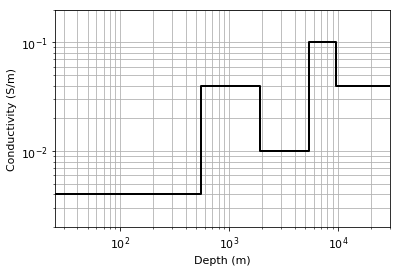

In [29]:
import matplotlib
matplotlib.rcParams["font.size"] = 11
# figsize(5, 2)
sigtrue = np.repeat(sigma, 2, axis=0)
z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
plt.plot(-z, sigtrue, 'k', lw=2)
plt.xscale("log")
plt.yscale("log")
plt.ylabel("Conductivity (S/m)")
plt.xlabel("Depth (m)")
plt.grid(True, which='both')
plt.ylim(2e-3, 2e-1)
plt.xlim(0, max_depth_core*2.)

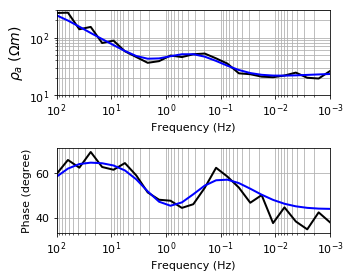

In [30]:
fig = plt.figure(figsize = (5, 4))
ax1 = plt.subplot(211)
ax2 = plt.subplot(212)
ax1.loglog(frequency, app_res, 'k-', lw=2)
ax1.loglog(frequency, app_res_true, 'b-', lw=2)
ax1.grid(True, which='both')
ax1.set_xlim(frequency.max(), frequency.min())
ax1.set_ylim(10, 3e2)
ax1.set_xlabel("Frequency (Hz)")
ax1.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)

ax2.semilogx(frequency, phase, 'k-', lw=2)
ax2.semilogx(frequency, phase_true, 'b-', lw=2)
ax2.grid(True, which='both')
ax2.set_xlim(frequency.max(), frequency.min())
ax2.set_xlabel("Frequency (Hz)")
ax2.set_ylabel("Phase (degree)")
plt.tight_layout()

In [31]:
def run_MT1Dinv(prob, survey, m0,
                std_appres=0.05, floor_phase =2.,
                alpha_s=1., alpha_x=1., coolingFactor=2., coolingRate=1, 
                beta0=1e1, beta0_ratio=None,
                use_betaest=False, use_target=True):
    dmisfit = DataMisfit.l2_DataMisfit(survey)
    dmisfit.W = 1./uncert
    reg = Regularization.Simple(prob.mesh, alpha_s=alpha_s, alpha_x=alpha_x)
    opt = Optimization.InexactGaussNewton(maxIter=35, LSshorten=0.5)
    invProb = InvProblem.BaseInvProblem(dmisfit, reg, opt)
    # Create an inversion object
    beta = Directives.BetaSchedule(coolingFactor=1.5, coolingRate=1)
    
    invProb.beta = beta0
    target = Directives.TargetMisfit()
    save = Directives.SaveOutputEveryIteration()
    directs = [beta, save]

    if use_target:
        directs.append(target)
    if use_betaest:
        if beta0_ratio is None:
            beta0_ratio = 1.
        betaest = Directives.BetaEstimate_ByEig(beta0_ratio=beta0_ratio)
        directs.append(betaest)      
        
    inv = Inversion.BaseInversion(invProb, directiveList=directs)
    prob.counter = opt.counter = Utils.Counter()
    opt.remember('xc')
    mopt = inv.run(m0)
    xc = opt.recall("xc")
    return xc, save, reg


In [32]:
m0 = np.log(0.01) * np.ones(mesh.nC)
xc, save, reg = run_MT1Dinv(prob, survey, m0,
                                   coolingFactor=8, coolingRate=3,
                                   alpha_s=1., alpha_x=1.,
                                   beta0_ratio=10.,
                                   use_betaest=True,
                                   use_target=False)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2017-06-18-18-38.txt'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  3.00e+02  1.72e+03  0.00e+00  1.72e+03    4.89e+02      0              
   1  2.00e+02  1.18e+03  8.30e-01  1.35e+03    1.00e+02      0              
   2  1.33e+02  1.06e+03  1.37e+00  1.24e+03    1.02e+02      0   Skip BFGS  
   3  8.89e+01  8.96e+02  2.41e+00  1.11e+03    8.71e+01      0              
   4  5.92e+01  7.35e+02  3.93e+00  9

In [33]:
save.load_results()

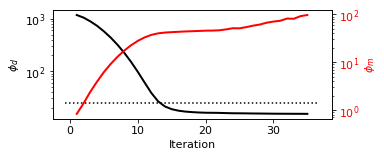

In [34]:
save.plot_misfit_curves(plot_small_smooth=False)

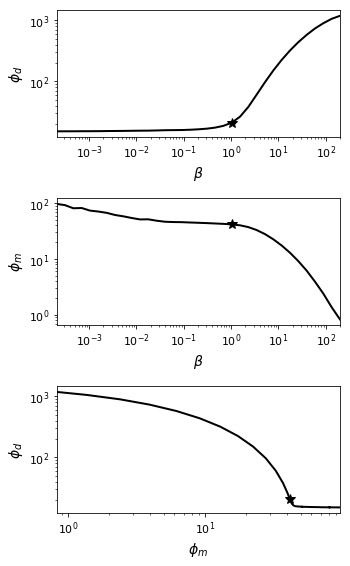

In [35]:
save.plot_tikhonov_curves()

In [36]:
save.i_target

13

In [37]:
from ipywidgets import interact, IntSlider, ToggleButtons
def view_1Dinversion_results(iteration, scale, save):
    fig = plt.figure(figsize = (10, 5))
    ax1 = plt.subplot(221)
    ax2 = plt.subplot(222)
    ax3 = plt.subplot(223)
    ax4 = plt.subplot(224)

    ax1.loglog(save.phi_m, save.phi_d, 'k-', lw=2)
    if save.i_target is not None:
        ax1.loglog(save.phi_m[save.i_target], save.phi_d[save.i_target], 'k*', ms=10)
    ax1.loglog(save.phi_m[iteration], save.phi_d[iteration], 'ro', ms=10)
    ax1.set_xlim(save.phi_m.min(), save.phi_m.max())
    ax1.set_xlabel("$\phi_m$", fontsize = 14)
    ax1.set_ylabel("$\phi_d$", fontsize = 14)
    ax1.set_xscale(scale)
    temp = xc[iteration]
    sigtrue = np.repeat(sigma, 2, axis=0)
    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
    ax3.plot(-z, sigtrue, 'k', lw=2)
    ax3.plot(-mesh.vectorCCx, np.exp(temp), 'k--', lw=2)
    ax3.set_xscale("log")
    ax3.set_yscale("log")
    ax3.set_ylabel("Conductivity (S/m)")
    ax3.set_xlabel("Depth (m)")
    ax3.grid(True, which='both')
    ax3.set_ylim(2e-3, 2e-1)
    ax3.set_xlim((-z).min(), (-z).max())
    dpred = survey.dpred(xc[iteration])
    app_res_pred, phase_pred = appres_phase_from_Zxy(dpred, frequency)
    ax2.loglog(frequency, app_res, 'k-', lw=2)
    ax2.loglog(frequency, app_res_pred, 'kx', markeredgewidth=1)
    ax2.grid(True, which='both')
    ax2.set_xlim(frequency.max(), frequency.min())
    ax2.set_ylim(10, 3e2)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)

    ax4.semilogx(frequency, phase, 'k-', lw=2)
    ax4.semilogx(frequency, phase_pred, 'kx', markeredgewidth=1)

    ax4.grid(True, which='both')
    ax4.set_xlim(frequency.max(), frequency.min())
    ax4.set_xlabel("Frequency (Hz)")
    ax4.set_ylabel("Phase (degree)")
    plt.tight_layout()
    plt.show()

def foo(iteration, scale):
    return view_1Dinversion_results(iteration, scale, save)
interact(foo, 
         iteration=IntSlider(min=0, max=save.phi_d.shape[0]-1, step=1, value=0),
         scale=ToggleButtons(options=["linear", "log"], value="log"))

<function __main__.foo>

In [38]:
def MT1D_inv_results(xc, iteration):
    fig = plt.figure(figsize = (5, 7))
    ax1 = plt.subplot(311)
    ax2 = plt.subplot(312)
    ax3 = plt.subplot(313)

    temp = xc[iteration]
    sigtrue = np.repeat(sigma, 2, axis=0)
    z = np.repeat(mesh.vectorCCx[1:], 2, axis=0)
    z = np.r_[mesh.vectorCCx[0], z, mesh.vectorCCx[-1]]
    ax1.plot(-z, sigtrue, 'k', lw=2)
    ax1.plot(-mesh.vectorCCx, np.exp(temp), 'k--', lw=2)
    ax1.set_xscale("log")
    ax1.set_yscale("log")
    ax1.set_ylabel("Conductivity (S/m)")
    ax1.set_xlabel("Depth (m)")
    ax1.grid(True, which='both')
    ax1.set_ylim(2e-3, 4e-1)
    ax1.set_xlim((-z).min(), (-z).max())

    dpred = survey.dpred(xc[iteration])
    app_res_pred, phase_pred = appres_phase_from_Zxy(dpred, frequency)
    
    ax2.loglog(frequency, app_res, 'k-', lw=2)
    ax2.loglog(frequency, app_res_pred, 'kx', markeredgewidth=1)
    ax2.grid(True, which='both')
    ax2.set_xlim(frequency.max(), frequency.min())
    ax2.set_ylim(10, 3e2)
    ax2.set_xlabel("Frequency (Hz)")
    ax2.set_ylabel("$\\rho_a \ (\Omega m)$", fontsize = 14)

    ax3.semilogx(frequency, phase, 'k-', lw=2)
    ax3.semilogx(frequency, phase_pred, 'kx', markeredgewidth=1)

    ax3.grid(True, which='both')
    ax3.set_xlim(frequency.max(), frequency.min())
    ax3.set_xlabel("Frequency (Hz)")
    ax3.set_ylabel("$\phi \ (^{\circ})$", fontsize = 14)
    plt.tight_layout()

In [39]:
m0 = np.log(0.01) * np.ones(mesh.nC)
xc_smooth, save_smooth, reg_smooth = run_MT1Dinv(prob, survey, m0,
                                   coolingFactor=8, coolingRate=3,
                                   alpha_s=1e-5, alpha_x=1.,
                                   beta0_ratio=1.,
                                   use_betaest=True,
                                   use_target=True)

SimPEG.DataMisfit.l2_DataMisfit assigning default eps of 1e-5 * ||dobs||
SimPEG.InvProblem will set Regularization.mref to m0.

    SimPEG.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
    ***Done using same Solver and solverOpts as the problem***
SimPEG.SaveOutputEveryIteration will save your inversion progress as: '###-InversionModel-2017-06-18-18-38.txt'
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  6.96e+01  1.72e+03  0.00e+00  1.72e+03    4.89e+02      0              
   1  4.64e+01  1.89e+02  3.06e-02  1.91e+02    7.29e+01      0              
   2  3.09e+01  4.33e+01  4.70e-01  5.79e+01    2.01e+01      0   Skip BFGS  
   3  2.06e+01  2.56e+01  5.99e-01  3.79e+01    4.63e+00      0              
------------------------- STOP! -----

In [ ]:
MT1D_inv_results(xc_smooth, -1)